In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

In [2]:
%matplotlib widget

In [3]:
YEAR = 2021

In [4]:
# load nsrdb data and converts datetime to GMT-8
df_NSRDB = pd.read_csv(f'./data/NSRDB_DonnaAv_{YEAR}.csv', header=2)
TS = [dt.datetime(x[0], x[1], x[2], x[3], x[4]) for x in df_NSRDB[['Year','Month','Day','Hour','Minute']].to_numpy()]
TSpst = [x - dt.timedelta(hours=8) for x in TS]
df_NSRDB.index = TSpst
# uses last day to fill make sure we have 1 year of data
df_fill = df_NSRDB[df_NSRDB.index > (df_NSRDB.index[-1]-pd.Timedelta(days=1))]
df_fill.index = df_fill.index + pd.Timedelta(days=1)
df_NSRDB = pd.concat([df_NSRDB, df_fill])

In [5]:
TSvec = np.array([[x.year, x.month, x.day, x.hour, x.minute] for x in df_NSRDB.index])
df_NSRDB['Year'] = TSvec[:,0]
df_NSRDB['Month'] = TSvec[:,1]
df_NSRDB['Day'] = TSvec[:,2]
df_NSRDB['Hour'] = TSvec[:,3]
df_NSRDB['Minute'] = TSvec[:,4]

In [6]:
#limits df to the YEAR
df_NSRDB = df_NSRDB[df_NSRDB['Year']==YEAR]

In [7]:
# writes fixed file
head = """Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,Local Time Zone,Clearsky DHI Units,Clearsky DNI Units,Clearsky GHI Units,Dew Point Units,DHI Units,DNI Units,GHI Units,Solar Zenith Angle Units,Temperature Units,Pressure Units,Relative Humidity Units,Precipitable Water Units,Wind Direction Units,Wind Speed Units,Cloud Type -15,Cloud Type 0,Cloud Type 1,Cloud Type 2,Cloud Type 3,Cloud Type 4,Cloud Type 5,Cloud Type 6,Cloud Type 7,Cloud Type 8,Cloud Type 9,Cloud Type 10,Cloud Type 11,Cloud Type 12,Fill Flag 0,Fill Flag 1,Fill Flag 2,Fill Flag 3,Fill Flag 4,Fill Flag 5,Surface Albedo Units,Version
NSRDB,201374,-,-,-,34.25,-118.42,-8,271,-8,w/m2,w/m2,w/m2,c,w/m2,w/m2,w/m2,Degree,c,mbar,%,cm,Degrees,m/s,N/A,Clear,Probably Clear,Fog,Water,Super-Cooled Water,Mixed,Opaque Ice,Cirrus,Overlapping,Overshooting,Unknown,Dust,Smoke,N/A,Missing Image,Low Irradiance,Exceeds Clearsky,Missing CLoud Properties,Rayleigh Violation,N/A,v3.2.2
Year,Month,Day,Hour,Minute,Temperature,DNI,GHI,DHI,Relative Humidity,Pressure,Wind Direction,Wind Speed\n"""
f2save = f'./data/DonnaAv_weather_{YEAR}_GMT-8.csv'
with open(f2save, 'w') as f:
    f.write(head)
# write the rest
df_NSRDB.to_csv(f2save, header=False, index=False, mode='a')

In [9]:
# loads experimental data and converts datetime to GMT-8
df_EXP = pd.read_csv(f'./data/ExpData-{YEAR}.csv', header=1, delimiter=';')
TS = np.array([dt.datetime.strptime(x,'%m/%d/%Y %H:%M:%S') for x in df_EXP['Date / Time'].to_numpy()])

if YEAR==2020:
    T0 = []
    T1 = []
elif YEAR==2021:
    T0 = dt.datetime(2021,3,14,3,0,0)
    T1 = dt.datetime(2021,11,7,2,0,0)

II = (TS <= T1) & (TS >= T0)
TS[II] = TS[II] - dt.timedelta(hours=1)

df_EXP.index = TS

In [11]:
# maps water usage and mais temp to the weather file TS
TSord = np.array([x.timestamp() for x in df_NSRDB.index])
HH = np.array([x.hour for x in df_NSRDB.index])

X = np.array([x.timestamp() for x in df_EXP.index])
Y = df_EXP['City Flowrate [ l/h]'].to_numpy()
USAGE = np.interp(TSord, X, Y)
Y = df_EXP['City Main Temperature [ °C]'].to_numpy()
MAINS = np.interp(TSord, X, Y)

Y = df_EXP['Ambient Temperature [ °C]'].to_numpy()
AMBT = np.interp(TSord, X, Y)

Y = df_EXP['Storage Tank Temperature [ °C]'].to_numpy()
Ttank = np.interp(TSord, X, Y)

In [12]:
# replaces temperature in the weather file
df_NSRDB_new = df_NSRDB.copy()
df_NSRDB_new['Temperature'] = AMBT

In [13]:
# writes fixed file
head = """Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,Local Time Zone,Clearsky DHI Units,Clearsky DNI Units,Clearsky GHI Units,Dew Point Units,DHI Units,DNI Units,GHI Units,Solar Zenith Angle Units,Temperature Units,Pressure Units,Relative Humidity Units,Precipitable Water Units,Wind Direction Units,Wind Speed Units,Cloud Type -15,Cloud Type 0,Cloud Type 1,Cloud Type 2,Cloud Type 3,Cloud Type 4,Cloud Type 5,Cloud Type 6,Cloud Type 7,Cloud Type 8,Cloud Type 9,Cloud Type 10,Cloud Type 11,Cloud Type 12,Fill Flag 0,Fill Flag 1,Fill Flag 2,Fill Flag 3,Fill Flag 4,Fill Flag 5,Surface Albedo Units,Version
NSRDB,201374,-,-,-,34.25,-118.42,-8,271,-8,w/m2,w/m2,w/m2,c,w/m2,w/m2,w/m2,Degree,c,mbar,%,cm,Degrees,m/s,N/A,Clear,Probably Clear,Fog,Water,Super-Cooled Water,Mixed,Opaque Ice,Cirrus,Overlapping,Overshooting,Unknown,Dust,Smoke,N/A,Missing Image,Low Irradiance,Exceeds Clearsky,Missing CLoud Properties,Rayleigh Violation,N/A,v3.2.2
Year,Month,Day,Hour,Minute,Temperature,DNI,GHI,DHI,Relative Humidity,Pressure,Wind Direction,Wind Speed\n"""
f2save = f'./data/DonnaAv_weather_{YEAR}_GMT-8_measTemp.csv'
with open(f2save, 'w') as f:
    f.write(head)
# write the rest
df_NSRDB_new.to_csv(f2save, header=False, index=False, mode='a')

In [14]:
# smooths mains temp
W = 24*60
MAINS_s = np.convolve(MAINS,np.ones((W,))/W, mode='same')

In [15]:
# writes water usage and mais temp
with open(f'./data/DonnaAv_{YEAR}_waterUSAGE.csv', 'w') as f:
    f.write('Wather usage\n')
    for y in USAGE:
        s = f'{y:.2f}\n'
        f.write(s)
with open(f'./data/DonnaAv_{YEAR}_waterMAINS.csv', 'w') as f:
    f.write('Wather usage\n')
    for y in MAINS:
        s = f'{y:.2f}\n'
        f.write(s)
with open(f'./data/DonnaAv_{YEAR}_waterMAINSsmooth.csv', 'w') as f:
    f.write('Wather usage\n')
    for y in MAINS_s:
        s = f'{y:.2f}\n'
        f.write(s)

In [22]:
# SAM resuls
# reads SAM results
df_R = pd.read_csv(f'./data/results.csv')
TS = [dt.datetime.strptime(f'{YEAR} ' + x, '%Y %b %d, %I:%M %p') for x in df_R['Time stamp']]
df_R.index = TS

df_R2 = pd.read_csv(f'./data/resultsCIMIS.csv')
TS = [dt.datetime.strptime(f'{YEAR} ' + x, '%Y %b %d, %I:%M %p') for x in df_R2['Time stamp']]
df_R2.index = TS

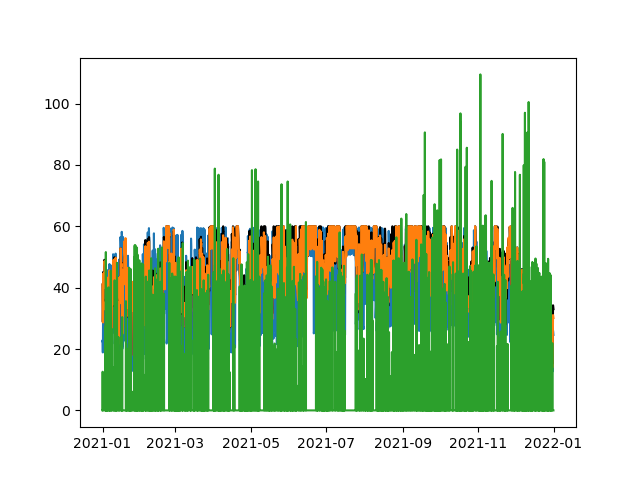

In [24]:
plt.figure()
# plt.plot(df_EXP['Ambient Temperature [ °C]'])
plt.plot(df_EXP['Storage Tank Temperature [ °C]'])
# plt.plot(df_EXP['City Main Temperature [ °C]'])
plt.plot(df_R['T tank | (C)'],'k')
plt.plot(df_R2['T tank | (C)'])
plt.plot(df_EXP['City Flowrate [ l/h]']/600*60)

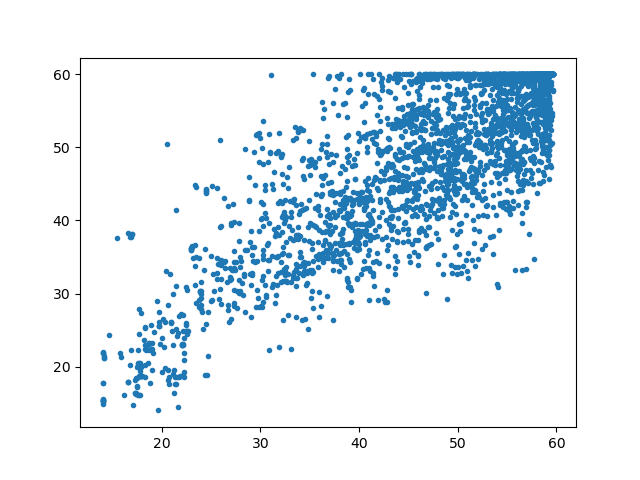

In [19]:
II = (HH>=10) & (HH<=17)
plt.figure()
plt.plot(Ttank[II], df_R['T tank | (C)'][II],'.')
# plt.plot(Ttank[II], df_R2['T tank | (C)'][II],'.')

In [144]:
plt.close('all')